# __TelecomX - Parte 2: Modelos de prediccion__

## __Objetivo__

La empresa busca anticiparse al problema de cancelacion de clientes, por lo que vamos a construir un pipeline robusto para la etapa inicial del modelado cuyas tareas son lo siguiente:

- Preparar los datos (limpieza, codificacion y normalizacion).
- Realizar analisis de correlacion y seleccion de variables.
- Entrenar diferentes modelos de clasificacion, evaluar el rendimiento a traves de distintas metricas e interpretar los resultados de cada uno.
- Crear un reporte con algunas recomendaciones sobre los principales factores que influyen en la cancelacion de clientes.

## __Importar Librerias__

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import warnings
#import requests
import pickle

from timeit import default_timer as timer
from datetime import datetime

import imblearn
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost
from xgboost import XGBClassifier

In [3]:
# version de las libreria utilizadas
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
print(f'matplotlib=={matplotlib.__version__}')
print(f'seaborn=={sns.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'imblearn=={sklearn.__version__}')
print(f'xgboost=={xgboost.__version__}')

numpy==2.2.6
pandas==2.3.1
matplotlib==3.10.3
seaborn==0.13.2
scikit-learn==1.6.1
imblearn==1.6.1
xgboost==3.0.5


## __Importar datos__

In [4]:
# cargar datos preprocesados desde GitHub
data = pd.read_csv('https://raw.githubusercontent.com/jbernalg/challenge_TelecomX/refs/heads/main/data_out/datos_tratados.csv', sep=',')
data.head()

,cancelacion,genero,jubilado,en_pareja,dependientes,meses_contrato,servicio_telefonico,multiples_lineas,servicio_internet,seguridad_online,...,proteccion_dispositivo,soporte_efectivo,streaming_TV,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cuenta_mensual,cuentas_total,cuentas_diarias
0,0,Femenino,No,Si,Si,9,Si,No,DSL,No,...,No,Si,Si,No,un year,Si,cheque por correo,65.6,593.30,0.242963
1,0,Masculino,No,No,No,9,Si,Si,DSL,No,...,No,No,No,Si,mes a mes,No,cheque por correo,59.9,542.40,0.221852
2,1,Masculino,No,No,No,4,Si,No,Fibra_optica,No,...,Si,No,No,No,mes a mes,Si,cheque electronico,73.9,280.85,0.615833
3,1,Masculino,Si,Si,No,13,Si,No,Fibra_optica,No,...,Si,No,Si,Si,mes a mes,Si,cheque electronico,98.0,1237.85,0.251282
4,1,Femenino,Si,Si,No,3,Si,No,Fibra_optica,No,...,No,Si,Si,No,mes a mes,Si,cheque por correo,83.9,267.40,0.932222


> Vamos a eliminar la variable _cuentas_diarias_ debido a que fue obtenida a partir de _cuenta_mensual_ por lo que no aporta informacion relevante.

In [5]:
datos = data.drop(['cuentas_diarias'], axis=1)
datos.head()

,cancelacion,genero,jubilado,en_pareja,dependientes,meses_contrato,servicio_telefonico,multiples_lineas,servicio_internet,seguridad_online,respaldo_online,proteccion_dispositivo,soporte_efectivo,streaming_TV,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cuenta_mensual,cuentas_total
0,0,Femenino,No,Si,Si,9,Si,No,DSL,No,Si,No,Si,Si,No,un year,Si,cheque por correo,65.6,593.30
1,0,Masculino,No,No,No,9,Si,Si,DSL,No,No,No,No,No,Si,mes a mes,No,cheque por correo,59.9,542.40
2,1,Masculino,No,No,No,4,Si,No,Fibra_optica,No,No,Si,No,No,No,mes a mes,Si,cheque electronico,73.9,280.85
3,1,Masculino,Si,Si,No,13,Si,No,Fibra_optica,No,Si,Si,No,Si,Si,mes a mes,Si,cheque electronico,98.0,1237.85
4,1,Femenino,Si,Si,No,3,Si,No,Fibra_optica,No,No,No,Si,Si,No,mes a mes,Si,cheque por correo,83.9,267.40


In [6]:
# resumen estadistico de las variables numericas
datos.describe()

,cancelacion,meses_contrato,cuenta_mensual,cuentas_total
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.265785,32.421786,64.798208,2283.300441
std,0.441782,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,1.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [7]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cancelacion              7032 non-null   int64  
 1   genero                   7032 non-null   object 
 2   jubilado                 7032 non-null   object 
 3   en_pareja                7032 non-null   object 
 4   dependientes             7032 non-null   object 
 5   meses_contrato           7032 non-null   int64  
 6   servicio_telefonico      7032 non-null   object 
 7   multiples_lineas         7032 non-null   object 
 8   servicio_internet        7032 non-null   object 
 9   seguridad_online         7032 non-null   object 
 10  respaldo_online          7032 non-null   object 
 11  proteccion_dispositivo   7032 non-null   object 
 12  soporte_efectivo         7032 non-null   object 
 13  streaming_TV             7032 non-null   object 
 14  streaming_peliculas     

## __Encoding de variables categoricas__

In [8]:
datos.columns

Index(['cancelacion', 'genero', 'jubilado', 'en_pareja', 'dependientes',
       'meses_contrato', 'servicio_telefonico', 'multiples_lineas',
       'servicio_internet', 'seguridad_online', 'respaldo_online',
       'proteccion_dispositivo', 'soporte_efectivo', 'streaming_TV',
       'streaming_peliculas', 'tipo_contrato', 'facturacion_electronica',
       'metodo_pago', 'cuenta_mensual', 'cuentas_total'],
      dtype='object')

In [9]:
# definir variables predictoras
X = datos.drop('cancelacion', axis=1)
# definir variable target
y = datos['cancelacion']

Vamos a crear un df llamado _df_linear_ el cual contendra las variables categoricas con `one_hot_encoder(drop='first')` y variables numericas escaladas para modelos sensibles a escalas y multicolinealidad. Con ello se busca evitar la "trampa de las variables ficticias" eliminando la primera categoría de cada variable.

In [10]:
X_linear = X.copy()
y_linear = y.copy()

In [11]:
# seleccionar variables categoricas manualmente
categoricas = ['genero', 'jubilado', 'en_pareja', 'dependientes', 'servicio_telefonico',
               'multiples_lineas', 'servicio_internet', 'seguridad_online', 'respaldo_online',
               'proteccion_dispositivo', 'soporte_efectivo', 'streaming_TV', 'streaming_peliculas', 
               'tipo_contrato', 'facturacion_electronica', 'metodo_pago']

In [12]:
one_hot_linear = make_column_transformer(
    (OneHotEncoder(drop='first'), categoricas),
    remainder='passthrough',
    sparse_threshold=0,
    force_int_remainder_cols=False # mantiene el nombre de las variables que no transforma
)

label_encoder = LabelEncoder()

In [13]:
X_linear = one_hot_linear.fit_transform(X_linear)
y_linear = label_encoder.fit_transform(y_linear)

In [14]:
columnas = one_hot_linear.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [15]:
df_linear = pd.DataFrame(X_linear, columns=columnas_encoded)
df_y_linear = pd.DataFrame(y_linear, columns=['cancelacion'])
df_linear = pd.concat([df_linear, df_y_linear], axis=1)
df_linear.head()

,genero_Masculino,jubilado_Si,en_pareja_Si,dependientes_Si,servicio_telefonico_Si,multiples_lineas_Si,multiples_lineas_sin servicio teleonico,servicio_internet_Fibra_optica,servicio_internet_No,seguridad_online_Si,...,tipo_contrato_mes a mes,tipo_contrato_un year,facturacion_electronica_Si,metodo_pago_cheque por correo,metodo_pago_tarjeta de credito,metodo_pago_transferencia,meses_contrato,cuenta_mensual,cuentas_total,cancelacion
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,9.0,65.6,593.30,0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,9.0,59.9,542.40,0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,4.0,73.9,280.85,1
3,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,13.0,98.0,1237.85,1
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,3.0,83.9,267.40,1


Ahora, vamos a crear un df llamado _df_ el cual contendra las variables categoricas codificadas con `one_hot_encoder(drop=if_binary)` y las variables numericas sin escalar para modelos robustos a escalas y multicolinealidad. Con ello se busca eliminar una categoria cuando la variable presenta 2 para asi evitar multicolinealidad. Util en modelos lineales.

In [16]:
one_hot = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categoricas),
    remainder = 'passthrough',
    sparse_threshold=0,
    force_int_remainder_cols=False
)

label_encoder = LabelEncoder()

In [17]:
X = one_hot.fit_transform(X)
y = label_encoder.fit_transform(y)

In [18]:
columnas = one_hot.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [19]:
df = pd.DataFrame(X, columns=columnas_encoded)
df_y = pd.DataFrame(y, columns=['cancelacion'])
df = pd.concat([df, df_y], axis=1)
df.head()

,genero_Masculino,jubilado_Si,en_pareja_Si,dependientes_Si,servicio_telefonico_Si,multiples_lineas_No,multiples_lineas_Si,multiples_lineas_sin servicio teleonico,servicio_internet_DSL,servicio_internet_Fibra_optica,...,tipo_contrato_un year,facturacion_electronica_Si,metodo_pago_cheque electronico,metodo_pago_cheque por correo,metodo_pago_tarjeta de credito,metodo_pago_transferencia,meses_contrato,cuenta_mensual,cuentas_total,cancelacion
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,9.0,65.6,593.30,0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,9.0,59.9,542.40,0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,4.0,73.9,280.85,1
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,13.0,98.0,1237.85,1
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,3.0,83.9,267.40,1


Vamos a definir un tercer df llamado _df_scale_ el cual contendra las variables categoricas codigicadas con `one_hot_encoder(drop=if_binary)` y variables numericas escalada para modelos robustos a multicolinealidad pero sensibles a escalas de los datos

In [20]:
df.columns

Index(['genero_Masculino', 'jubilado_Si', 'en_pareja_Si', 'dependientes_Si',
       'servicio_telefonico_Si', 'multiples_lineas_No', 'multiples_lineas_Si',
       'multiples_lineas_sin servicio teleonico', 'servicio_internet_DSL',
       'servicio_internet_Fibra_optica', 'servicio_internet_No',
       'seguridad_online_Si', 'respaldo_online_Si',
       'proteccion_dispositivo_Si', 'soporte_efectivo_Si', 'streaming_TV_Si',
       'streaming_peliculas_Si', 'tipo_contrato_dos years',
       'tipo_contrato_mes a mes', 'tipo_contrato_un year',
       'facturacion_electronica_Si', 'metodo_pago_cheque electronico',
       'metodo_pago_cheque por correo', 'metodo_pago_tarjeta de credito',
       'metodo_pago_transferencia', 'meses_contrato', 'cuenta_mensual',
       'cuentas_total', 'cancelacion'],
      dtype='object')

In [21]:
df.rename(columns={'servicio_internet_No': 'No_servicio_internet'}, inplace=True)
df_linear.rename(columns={'servicio_internet_No': 'No_servicio_internet'}, inplace=True)

In [22]:
df_scale = df.copy()

## __Normalizacion de datos__

En lo que sigue, analizamos la distribucion de las variables numericas y aplicamos diferentes transformaciones para ver si es posible llevarla a una distribucion lineal. Ademas, normalizamos los datos utilizando dos metodos para explorar y comparar lo forma de cada variable y decidir cual usar en funcion del modelo y la presencia de outliers.

In [23]:
# funcion que implementa la regla Freedman-Diaconis para calcular el ancho optimo
# de los bins
def bin_width(df, columna):
    n = df.shape[0]
    iqr = df[columna].quantile(0.75) - df[columna].quantile(0.25)
    bin_width = 2*(iqr/np.cbrt(n))
    return bin_width

In [24]:
# definimos los objetos Scaler para cada variable numerica

# StandarScaler usa media y STD lo que lo hace sensible a outliers
scaler_meses_contrato = StandardScaler()
scaler_cuenta_mensual = StandardScaler()
scaler_cuentas_total = StandardScaler()

# RobustScaler usa la mediana y el IQR lo que lo hace resistente a outliers
robust_meses_contrato = RobustScaler()
robust_cuenta_mensual = RobustScaler()
robust_cuentas_total = RobustScaler()

__Meses Contrato__

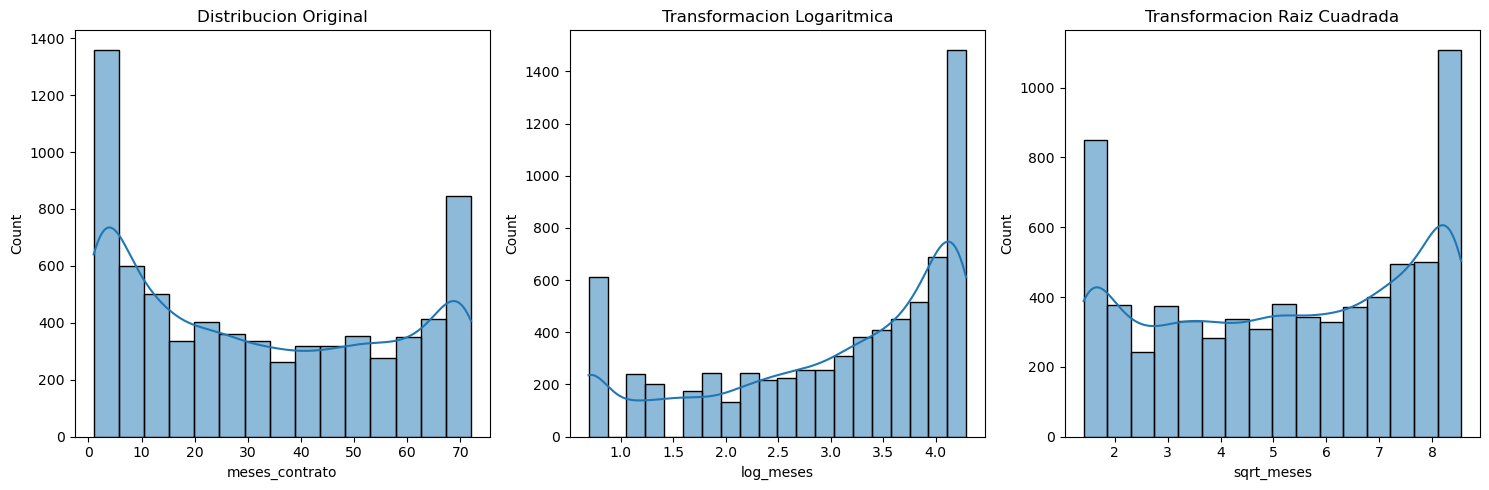

In [25]:
# visualizacion de la distribucion meses_contrato y las diferentes transformaciones

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Distribucion Original
BIN_WIDTH = bin_width(df, 'meses_contrato')
sns.histplot(df['meses_contrato'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title("Distribucion Original")

# Transformacion Logaritmica
df['log_meses'] = np.log(df['meses_contrato'] + 1)
BIN_WIDTH = bin_width(df, 'log_meses')
sns.histplot(df['log_meses'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title("Transformacion Logaritmica")

# Transformacion Raíz cuadrada
df['sqrt_meses'] = np.sqrt(df['meses_contrato'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_meses')
sns.histplot(df['sqrt_meses'], binwidth=BIN_WIDTH, kde=True, ax=axes[2])
axes[2].set_title("Transformacion Raiz Cuadrada")

plt.tight_layout()
plt.show()


- Claramente vemos que la distribucion _meses_contrato_ es bimodal.

- Tras aplicar la transformacion logaritmica, se sigue evidenciando una distribucion bimodal.

- Lo mismo se muestra al aplicar la transformacion raiz cuadrada.

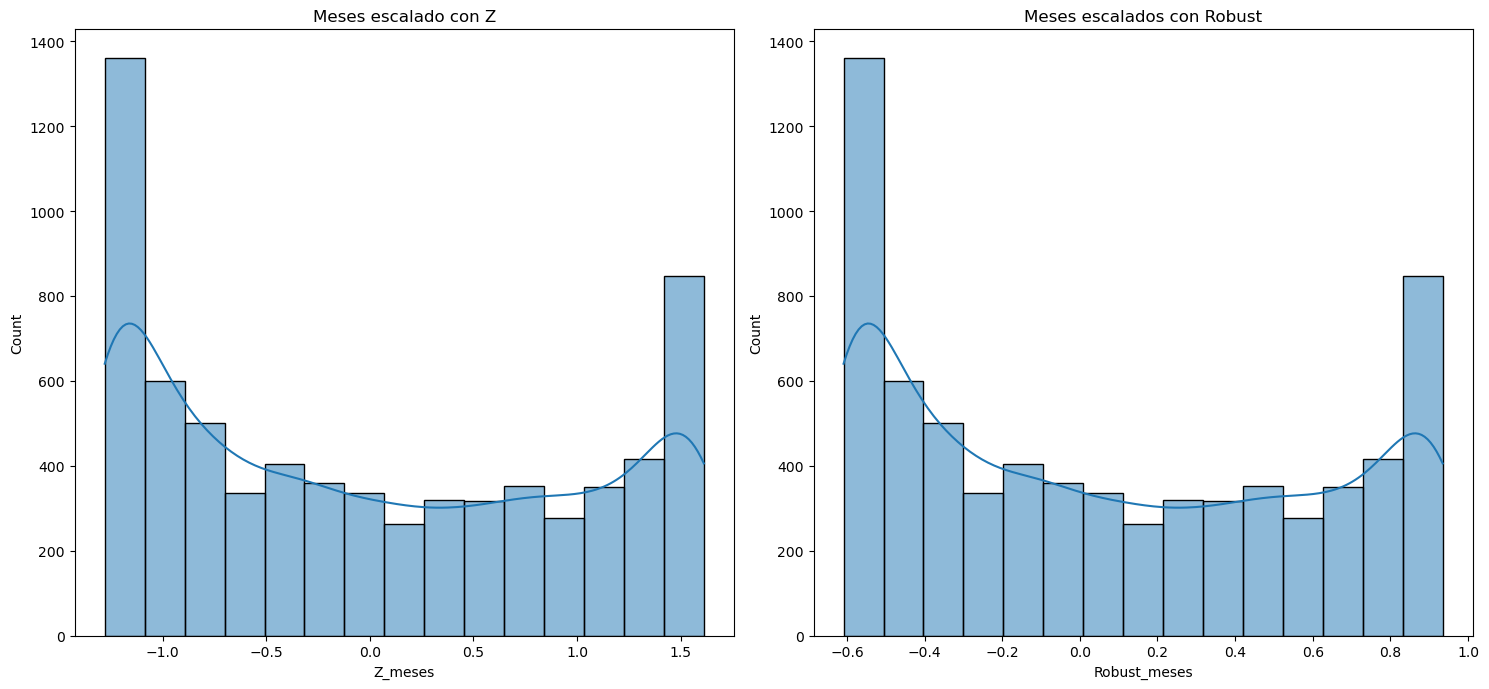

In [26]:
# visualizacion de meses_contrato escalados de forma estandar y robusta

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# meses_contrato escalado con StandarScaler
df['Z_meses'] = scaler_meses_contrato.fit_transform(df[['meses_contrato']])
BIN_WIDTH = bin_width(df, 'Z_meses')
sns.histplot(df['Z_meses'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title('Meses escalado con Z')

# meses_contrato escalado con RobustScaler
df['Robust_meses'] = robust_meses_contrato.fit_transform(df[['meses_contrato']])
BIN_WIDTH = bin_width(df, 'Robust_meses')
sns.histplot(df['Robust_meses'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title('Meses escalados con Robust')

plt.tight_layout()
plt.show()

- Z_meses muestra mas influencia de los valores extremos que de outliers. La forma de la distribucion no cambia

- Robust_meses tiene centrado mejor los valores tipicos por lo que es mas adecuado para outliers. La distribucion esta mas controlada y menos distorcionada.

- Si se usa un modelo sensible a outliers, Robust_meses seria mas apropiado.

__Cuenta Mensual__

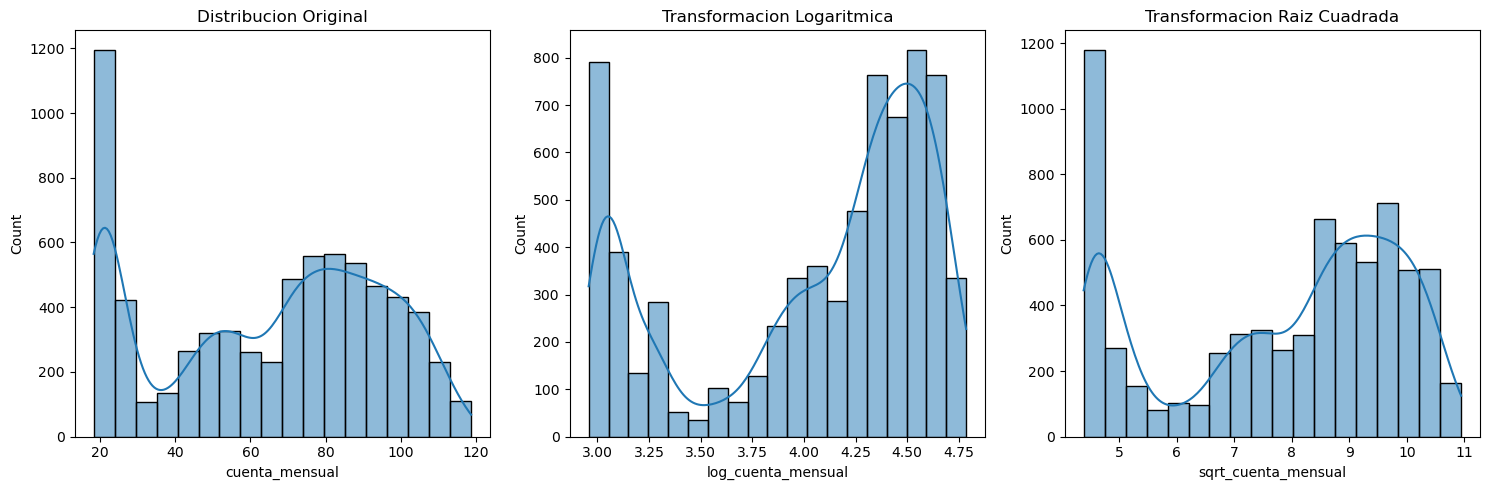

In [27]:
# visualizacion de la distribucion cuenta_mensual y las diferentes transformaciones

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Distribucion Original
BIN_WIDTH = bin_width(df, 'cuenta_mensual')
sns.histplot(df['cuenta_mensual'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title("Distribucion Original")

# Transformacion Logaritmica
df['log_cuenta_mensual'] = np.log(df['cuenta_mensual'] + 1)
BIN_WIDTH = bin_width(df, 'log_cuenta_mensual')
sns.histplot(df['log_cuenta_mensual'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title("Transformacion Logaritmica")

# Transformacion Raíz cuadrada
df['sqrt_cuenta_mensual'] = np.sqrt(df['cuenta_mensual'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_cuenta_mensual')
sns.histplot(df['sqrt_cuenta_mensual'], binwidth=BIN_WIDTH, kde=True, ax=axes[2])
axes[2].set_title("Transformacion Raiz Cuadrada")

plt.tight_layout()
plt.show()


- La distribucion cuenta_mensual es bimodal.

- Al aplicar la transformacion logaritmical y raiz cuadrada sigue mostrando una forma bimodal.

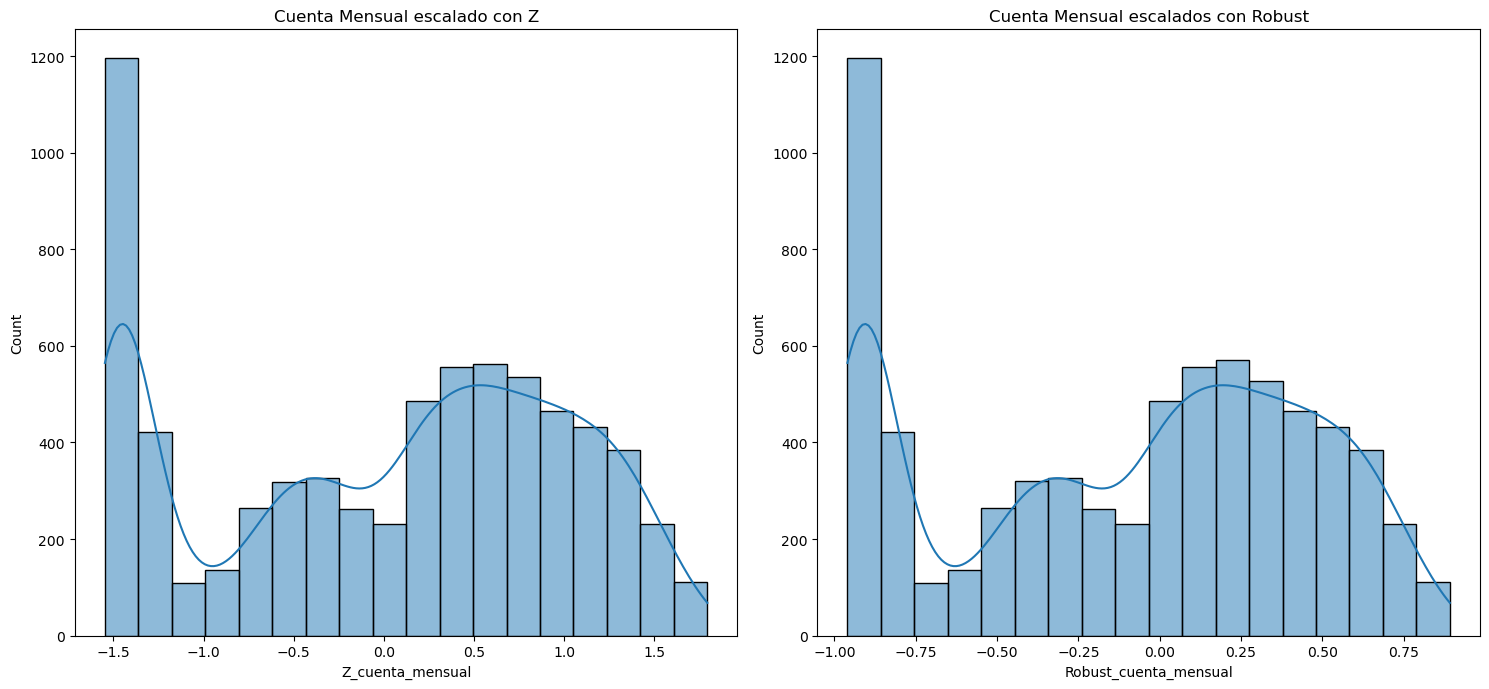

In [28]:
# visualizacion de cuenta_mensual escalados de forma estandar y robusta

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# meses_contrato escalado con StandarScaler
df['Z_cuenta_mensual'] = scaler_cuenta_mensual.fit_transform(df[['cuenta_mensual']])
BIN_WIDTH = bin_width(df, 'Z_cuenta_mensual')
sns.histplot(df['Z_cuenta_mensual'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title('Cuenta Mensual escalado con Z')

# meses_contrato escalado con RobustScaler
df['Robust_cuenta_mensual'] = robust_cuenta_mensual.fit_transform(df[['cuenta_mensual']])
BIN_WIDTH = bin_width(df, 'Robust_cuenta_mensual')
sns.histplot(df['Robust_cuenta_mensual'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title('Cuenta Mensual escalados con Robust')

plt.tight_layout()
plt.show()

- Ambos metodos preservan la distribucion original.

- La distribucion presenta muchos valores bajos concentrados y una cola larga hacia la derecha por lo que es mas adecuado Robust_cuenta_mensual para modelos sensibles a outliers.

__Cuenta Total__

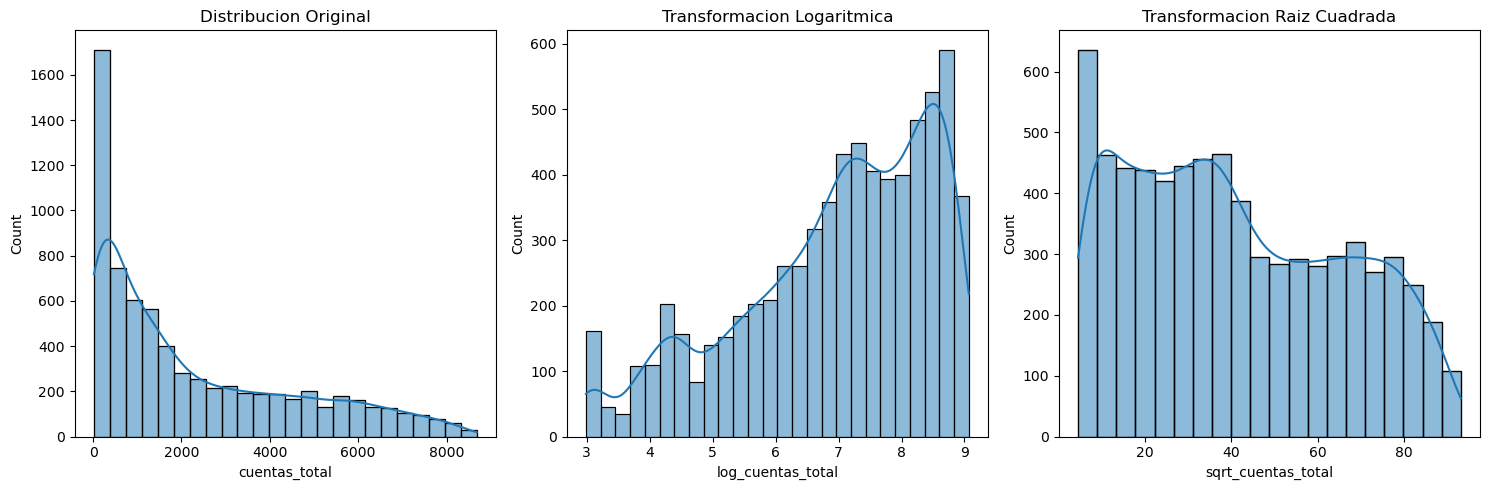

In [29]:
# visualizacion de la distribucion cuentas_total y las diferentes transformaciones

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Distribucion Original
BIN_WIDTH = bin_width(df, 'cuentas_total')
sns.histplot(df['cuentas_total'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title("Distribucion Original")

# Transformacion Logaritmica
df['log_cuentas_total'] = np.log(df['cuentas_total'] + 1)
BIN_WIDTH = bin_width(df, 'log_cuentas_total')
sns.histplot(df['log_cuentas_total'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title("Transformacion Logaritmica")

# Transformacion Raíz cuadrada
df['sqrt_cuentas_total'] = np.sqrt(df['cuentas_total'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_cuentas_total')
sns.histplot(df['sqrt_cuentas_total'], binwidth=BIN_WIDTH, kde=True, ax=axes[2])
axes[2].set_title("Transformacion Raiz Cuadrada")

plt.tight_layout()
plt.show()


- La distribucion de cuentas_total presenta asimetria positiva.

- Ninguna de las transformaciones aplicadas logra corregir dicha asimetria.

- Debido a su naturaleza acumulativa, se espera que la mayor concentracion de observaciones se encuentre en valores pequenos teniendo solo valores altos para un grupo seleccionado de clientes, por ejemplo.

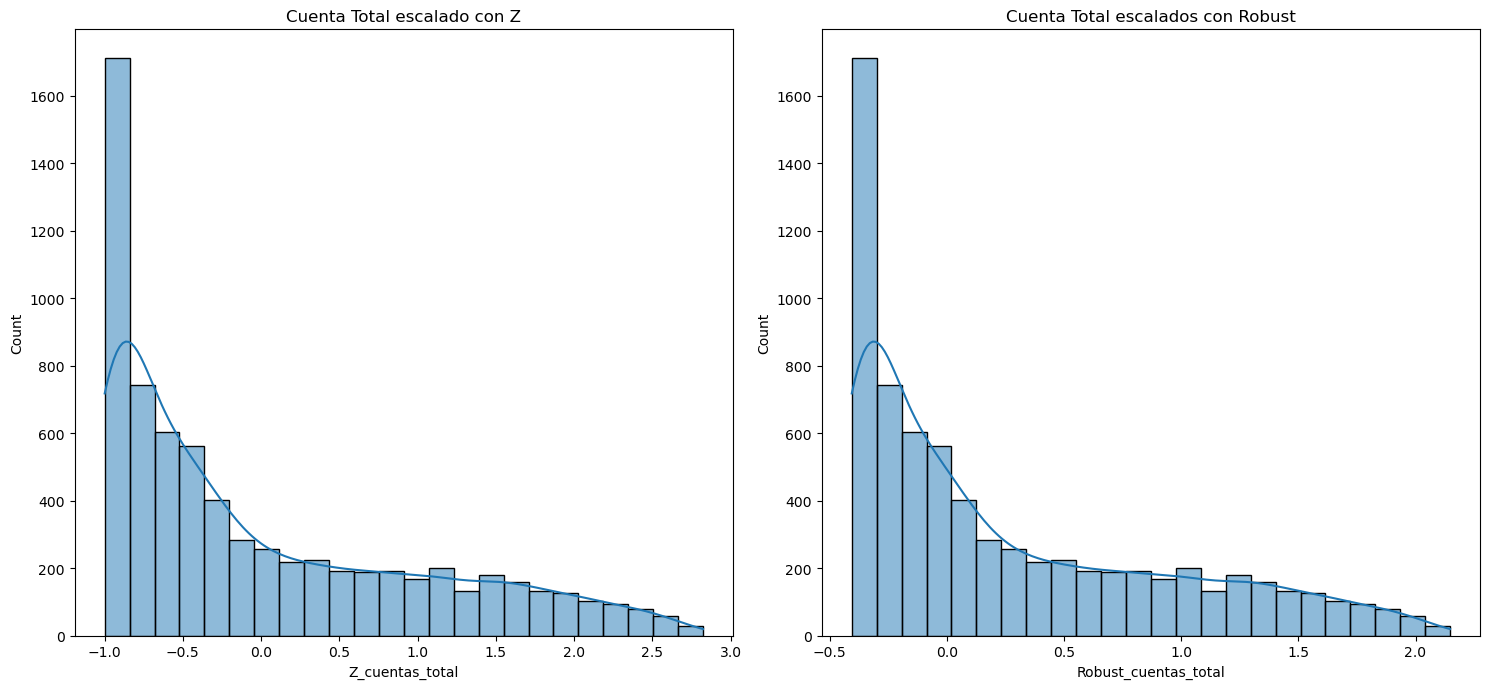

In [30]:
# visualizacion de cuenta_total escalados de forma estandar y robusta

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# meses_contrato escalado con StandarScaler
df['Z_cuentas_total'] = scaler_cuentas_total.fit_transform(df[['cuentas_total']])
BIN_WIDTH = bin_width(df, 'Z_cuentas_total')
sns.histplot(df['Z_cuentas_total'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title('Cuenta Total escalado con Z')

# meses_contrato escalado con RobustScaler
df['Robust_cuentas_total'] = robust_cuenta_mensual.fit_transform(df[['cuentas_total']])
BIN_WIDTH = bin_width(df, 'Robust_cuentas_total')
sns.histplot(df['Robust_cuentas_total'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title('Cuenta Total escalados con Robust')

plt.tight_layout()
plt.show()

- Ambos metodos preservan la distribucion original.

Vamos a trabajar con las variables numericas en su estado original y evaluar si los modelos son capaces de interpretarlas correctamente. En caso contrario, utilizaremos las variables escaladas con RobustScaler

In [31]:
df = df.drop(['log_meses', 'sqrt_meses', 'Z_meses', 'Robust_meses',
              'log_cuenta_mensual', 'sqrt_cuenta_mensual', 'Z_cuenta_mensual', 'Robust_cuenta_mensual',
              'log_cuentas_total', 'sqrt_cuentas_total', 'Z_cuentas_total', 'Robust_cuentas_total'], axis=1)

df.shape

(7032, 29)

## __Analisis de Correlacion__

Analizamos la correlacion entre la variable _cancelacion_ y las demas.

In [32]:
corr = df.corr()

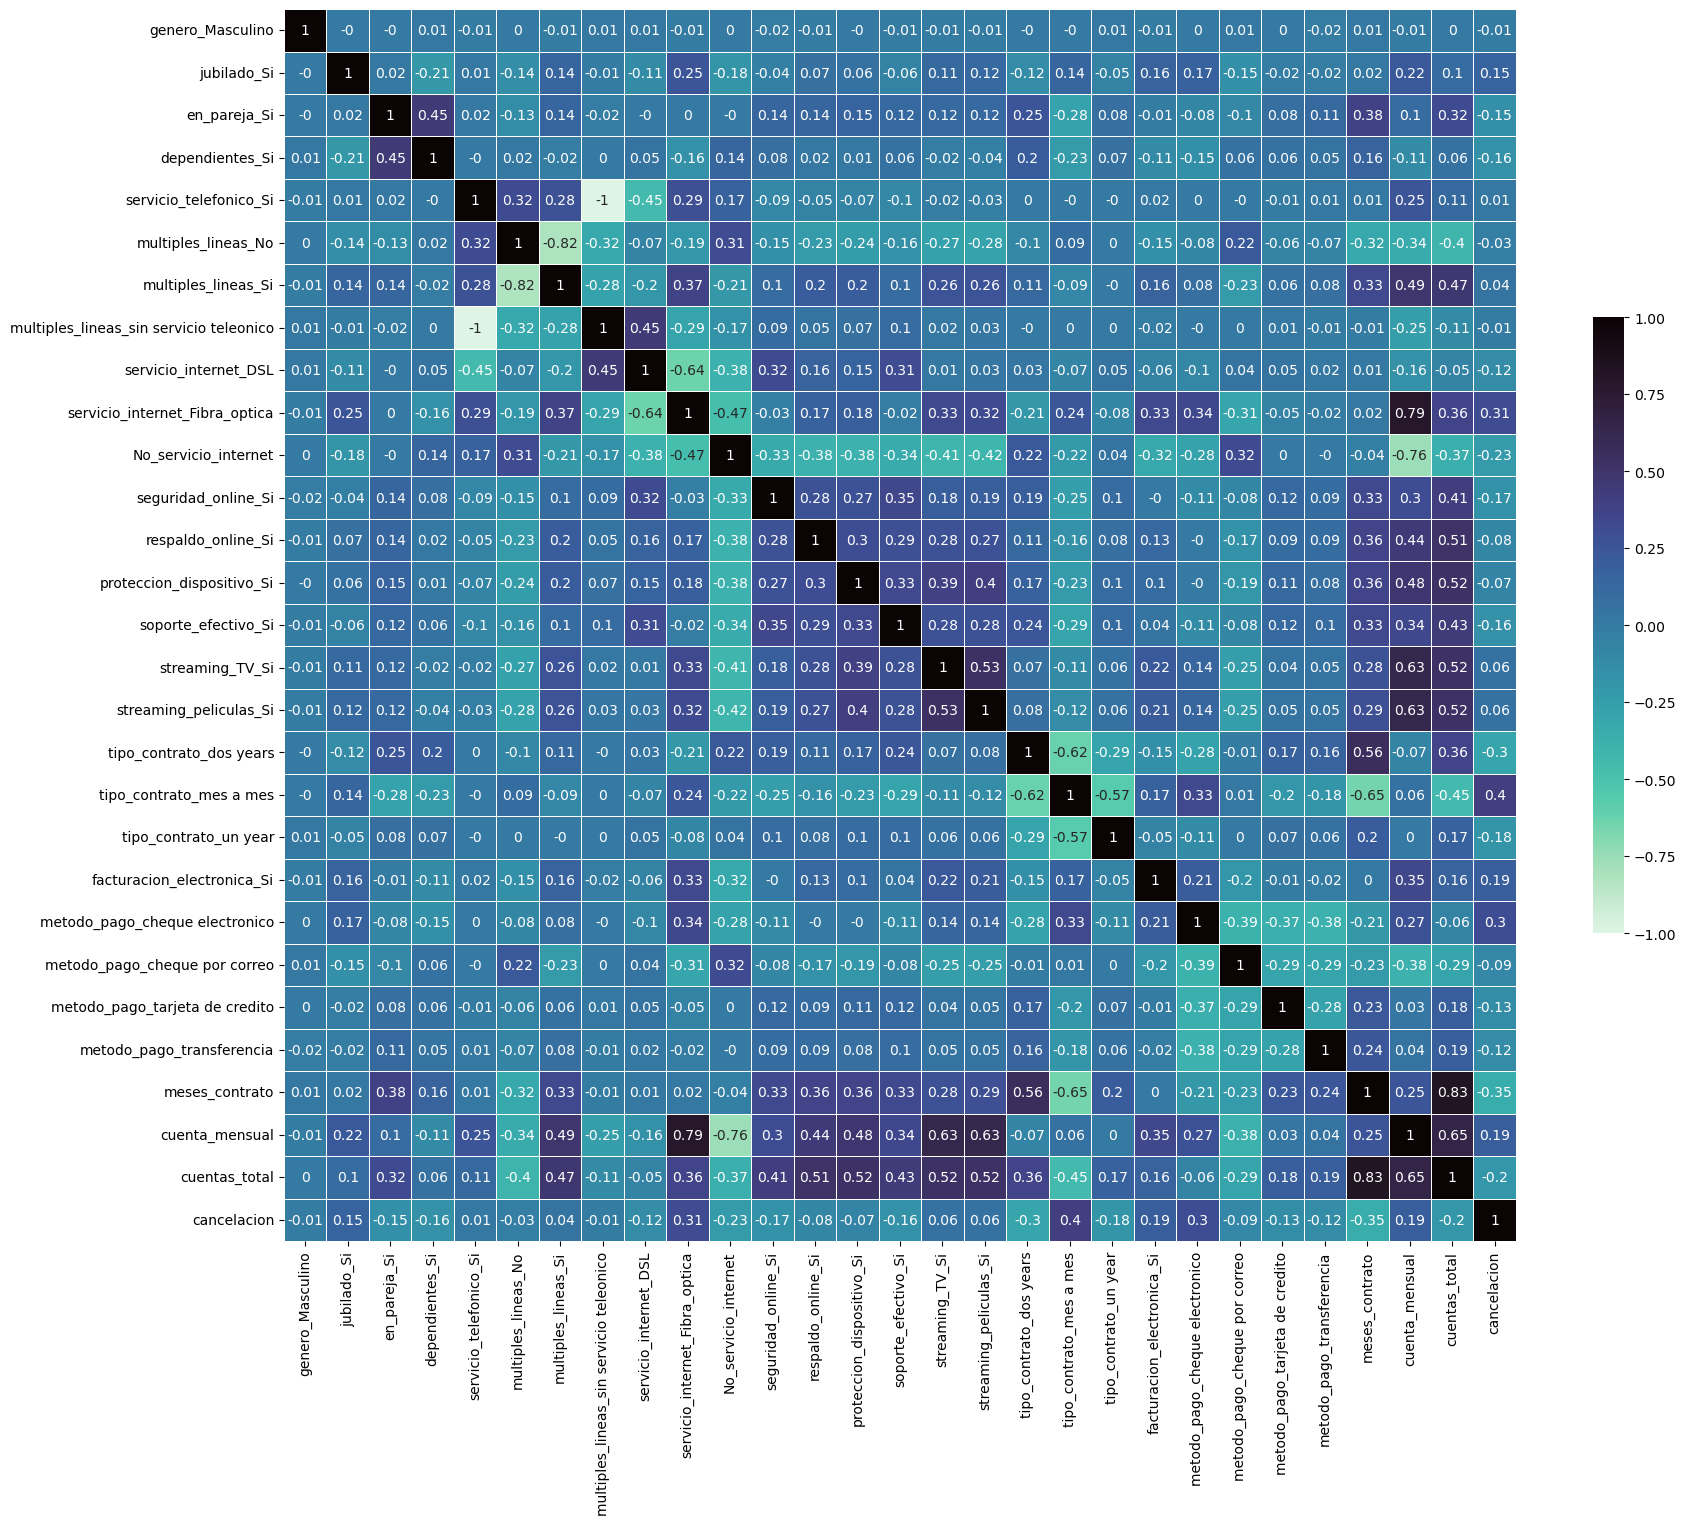

In [33]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(
    np.round(corr, 2), 
    vmax=1, 
    vmin=-1, 
    center=0,
    square=True,
    linewidths=.5,
    annot=True,
    cbar_kws={'shrink': .5},
    cmap='mako_r'
    )
plt.show()

Debido a la gran cantidad de variables predictoras, vamos a filtrar aquellas cuya correlacion absoluta con _cancelacion_ sea mayor a 0.07

In [34]:
vars = corr.loc['cancelacion'].abs()[corr.loc['cancelacion'].abs() > 0.07].index
corr_selected = corr[vars].loc[vars]

In [35]:
# mascar sobre el triangulo superior del heatmap
masc = np.zeros_like(corr_selected, dtype=bool)
masc[np.triu_indices_from(masc)] = True

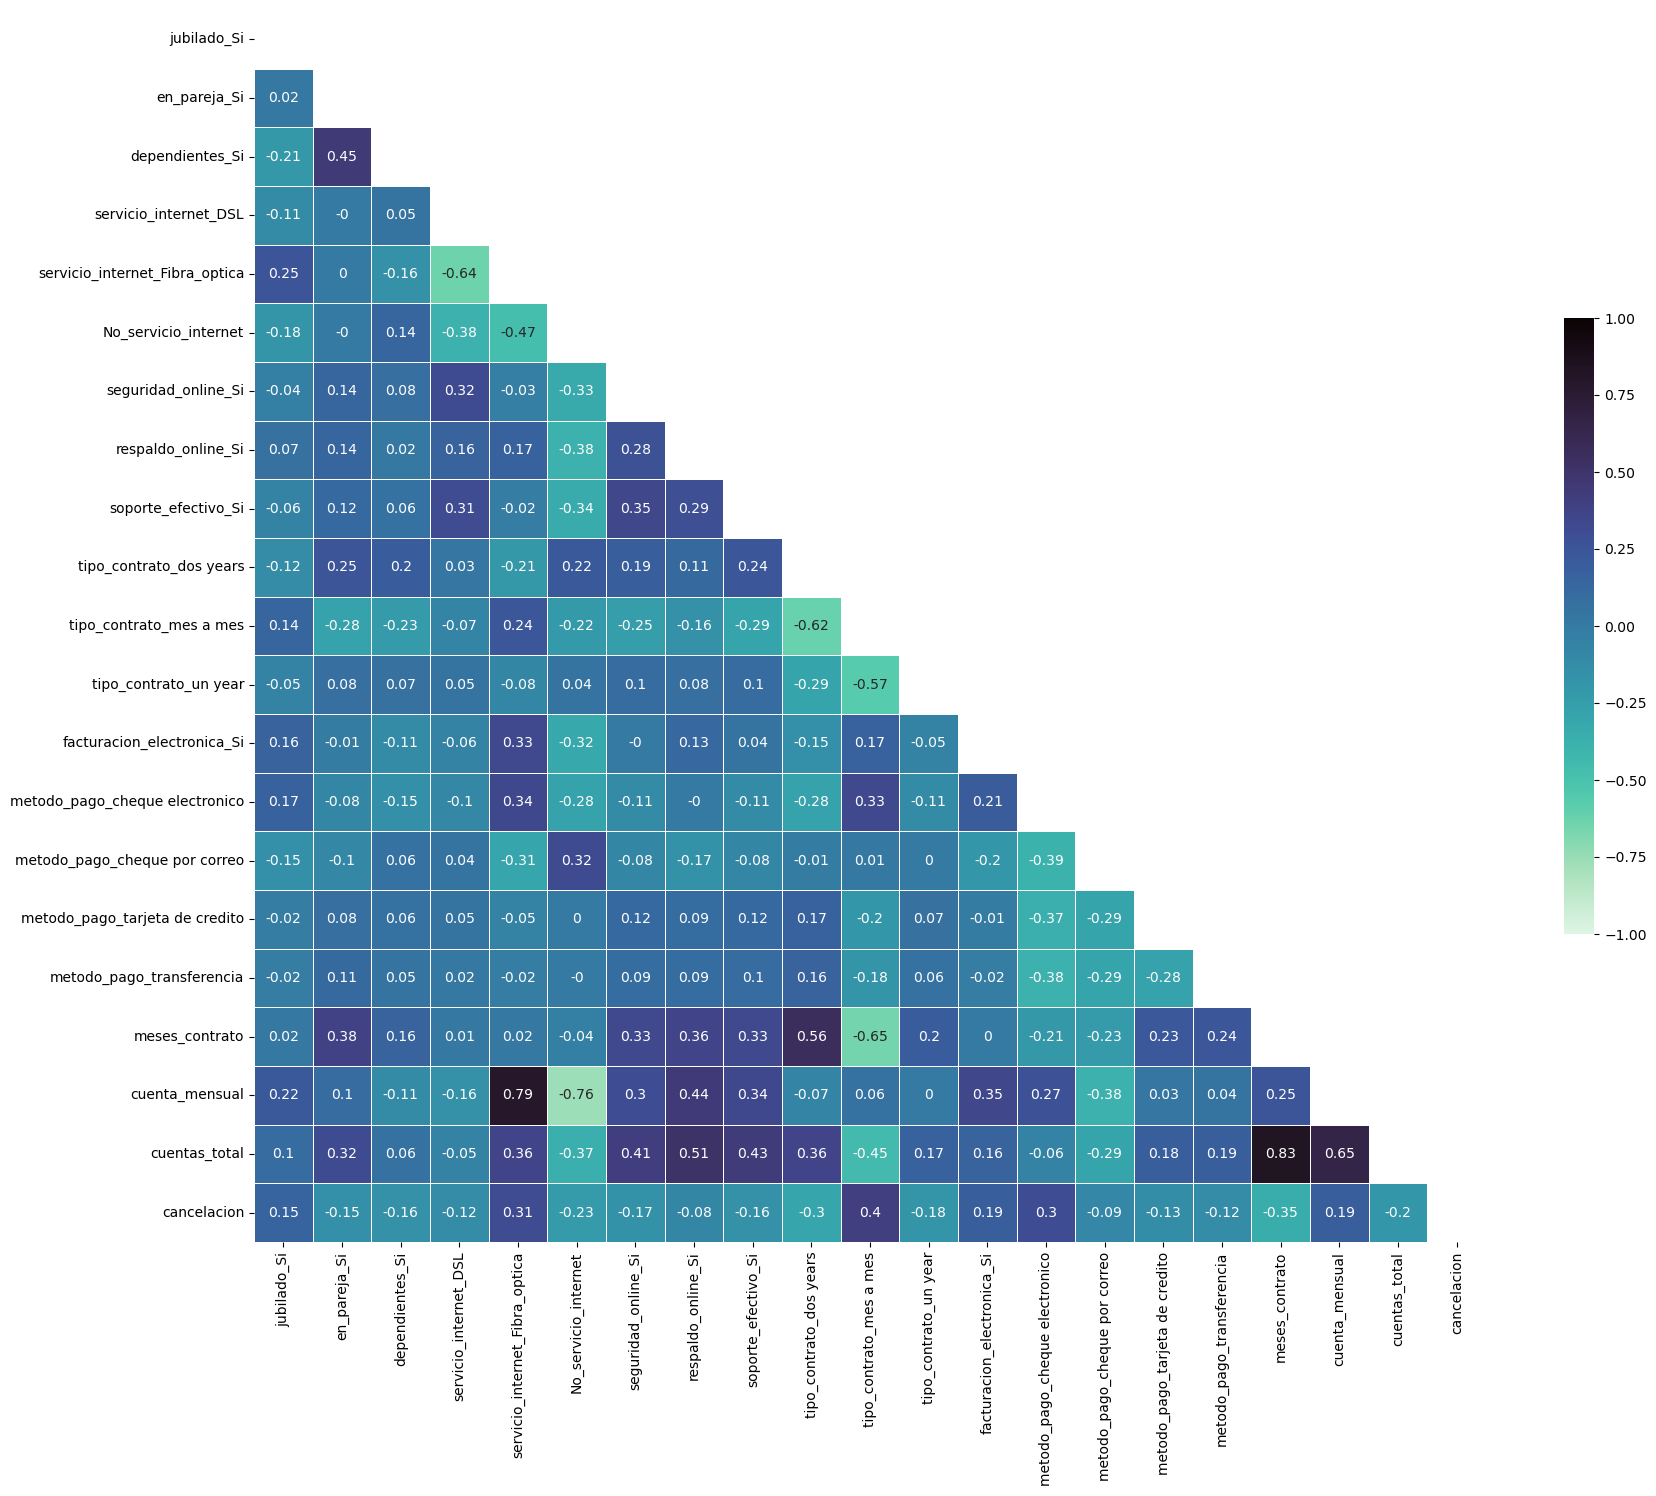

In [36]:
# visualizacion del heatmap con variables filtradas
fig, ax = plt.subplots(figsize=(20,16))

ax = sns.heatmap(
    np.round(corr_selected, 2), 
    mask=masc, 
    vmax=1, 
    vmin=-1, 
    center=0,
    square=True,
    linewidths=.5,
    annot=True,
    cbar_kws={'shrink': .5},
    cmap='mako_r'
    )

plt.show()

- Resalta una fuerte correlacion entre _cuenta_total_ y _meses_contrato_ (de 0.83). Esto puede deberse a la naturaleza acumulativa de _cuentas_total_, por lo que es posible que esta variable sea explicada con _meses_contrato_ y _cuenta_mensual_.

- Para verificar lo anterior, realizamos un analisis de multicolinealidad a traves del factor __Variance Inflation_Factor__

## __Analisis de Multicolinealidad__

El Variance Inflation Factor realiza una regresion lineal tomando cada variable predictora como variable target y busca explicarlas a traves del resto de variables predictoras. La interpretacion del valor de este factor es la siguiente:

- 1 < VIF < 5, Aceptable.

- 5 < VIF < 10, la variable puede conservarse si se considera necesaria.

- 1 < VIF, Existe colinealidad fuerte entre dicha variable y alguna de las otras variables predictoras. Deben descartarse.

Vamos a utilizar las variables codificadas OneHotEncoder _X_linear_ para asegurar que se descarte la primera categoria de cada feature, evitando que se introduzca multicolinealidad. Tambien vamos a escalar las variables numericas ya que el algoritmo de VIF es sensible a la escala de los datos.

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import RobustScaler

In [38]:
# instanciamos RobustScaler
vif_robust_scaler = RobustScaler()

# copia del df_linear
df_vif = df_linear.copy()

# extraer variable numericas que se van a escalar
x_num = ['meses_contrato', 'cuenta_mensual', 'cuentas_total']
x_vif_num = df_vif[x_num]

# aplicar escalado robusto
x_vif_num = vif_robust_scaler.fit_transform(x_vif_num)

# crear nuevas variables escaladas
df_vif[['robust_meses_contrato', 'robust_cuenta_mensual', 'robust_cuentas_total']] = x_vif_num

# eliminar las variables originales del df_vif
df_vif = df_vif.drop(x_num, axis=1)

# Obtener variables predictoras
X_vif = df_vif.drop('cancelacion', axis=1)

# obtener nombre de las variables predictoras
features = X_vif.columns

# crear un df vacio
df_vif_1 = pd.DataFrame()

# agregar variable con los nombres de las variables predictoras
df_vif_1['Features'] = features

# calcular el VIF para cada variable
df_vif_1['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

# ordenar los resultados y mostrarlos
df_vif_1.sort_values('VIF', ascending=False)


,Features,VIF
22,robust_cuenta_mensual,866.089640
4,servicio_telefonico_Si,578.341895
6,multiples_lineas_sin servicio teleonico,193.449293
7,servicio_internet_Fibra_optica,148.500814
8,No_servicio_internet,104.213701
14,streaming_peliculas_Si,24.156394
13,streaming_TV_Si,24.080019
23,robust_cuentas_total,10.811490
21,robust_meses_contrato,7.584453
5,multiples_lineas_Si,7.289761


> Observamos que las variables _robust_cuenta_mensual_ y _robust_cuentas_total_ presentan un valor de VIF elevado. Por tanto, vamos a descartar la cuenta mensual y ver nuevamente los valores de VIF. 

In [39]:
X_vif = df_vif.copy()

X_vif = X_vif.drop(['robust_cuentas_total', 'cancelacion'], axis=1)

features = X_vif.columns

df_vif_2 = pd.DataFrame()
df_vif_2['Features'] = features
df_vif_2['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

df_vif_2.sort_values('VIF', ascending=False)

,Features,VIF
22,robust_cuenta_mensual,863.723924
4,servicio_telefonico_Si,578.321360
6,multiples_lineas_sin servicio teleonico,193.441391
7,servicio_internet_Fibra_optica,148.500782
8,No_servicio_internet,104.133342
14,streaming_peliculas_Si,24.150902
13,streaming_TV_Si,24.075758
5,multiples_lineas_Si,7.286726
11,proteccion_dispositivo_Si,6.906050
10,respaldo_online_Si,6.761657


## __Analisis Visual__

### _Cuenta total basado en la cancelacion_

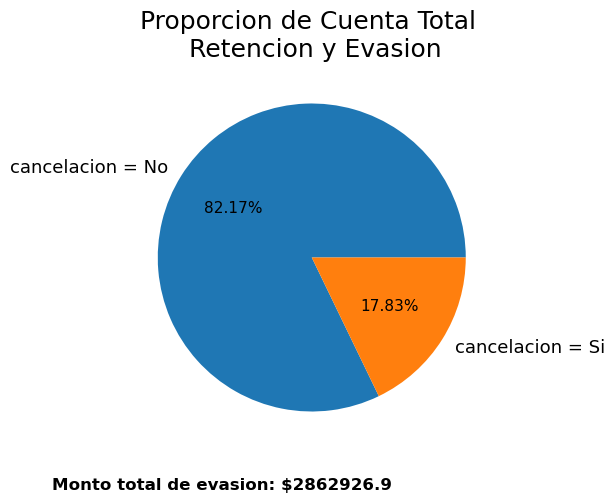

In [40]:
totals = datos.groupby('cancelacion')['cuentas_total'].sum().reset_index()
cancela = totals[totals['cancelacion'] == 1]

fig, ax = plt.subplots(figsize=(8,5))

wedges, texts, autotexts = ax.pie(
    data=totals,
    x='cuentas_total',
    autopct='%1.2f%%',
    labels=['cancelacion = No', 'cancelacion = Si'],
    startangle=0
    )

for t in texts:
    t.set_fontsize(13)
for a in autotexts:
    a.set_fontsize(11)

plt.title('Proporcion de Cuenta Total \n Retencion y Evasion', fontsize=18)
plt.figtext(
    0.4, 
    0.03, 
    f'Monto total de evasion: ${cancela["cuentas_total"].values[0]}',
    ha='center',
    fontsize=12,
    fontweight='bold'
    )

plt.show()

### _Cancelacion segun antiguedad del cliente_

In [41]:
def boxplot_churn(df: pd.DataFrame,
                  ycol: str,
                  ylabel: str=None,
                  title_translate: str=None):
    
    """    
    Genera y guarda un boxplot que muestra la distribución de una variable numérica 
    (`ycol`) según la condición de churn de los clientes.
    """

    if ylabel is None:
        ylabel = ycol
    if title_translate is None:
        title_translate = ycol
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax = sns.boxplot(data=df, x='cancelacion', y=ycol, hue='cancelacion')
    plt.title(f'Distribución de {title_translate} según\nCancelacion de clientes', fontsize=18, pad=20)
    plt.xlabel('Cancelacion', fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xticks(fontsize=13)
    plt.grid(True)
    plt.show()
    return fig

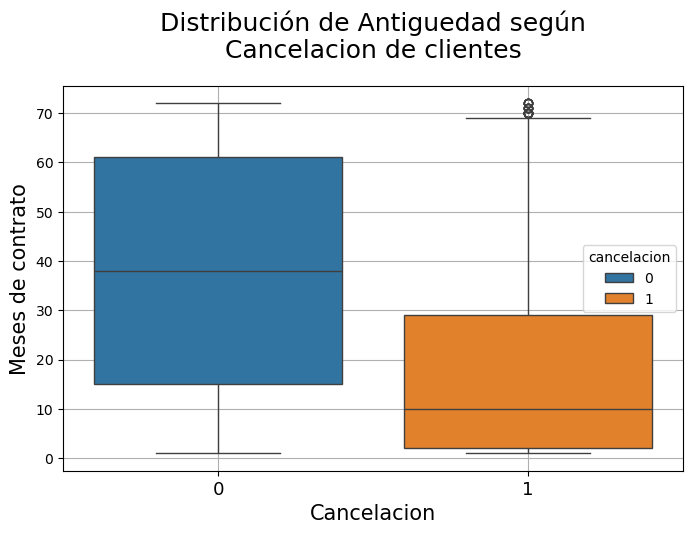

In [42]:
duracion_boxplot = boxplot_churn(df, ycol='meses_contrato', ylabel='Meses de contrato', title_translate='Antiguedad')

> Se observa que la frecuencia de abandono es mayor en etapas tempranas de la relacion del cliente con la empresa, con una concentracion del 50% de cancelacion antes del primer año de contrato

### _Cancelacion segun el Gasto Total_

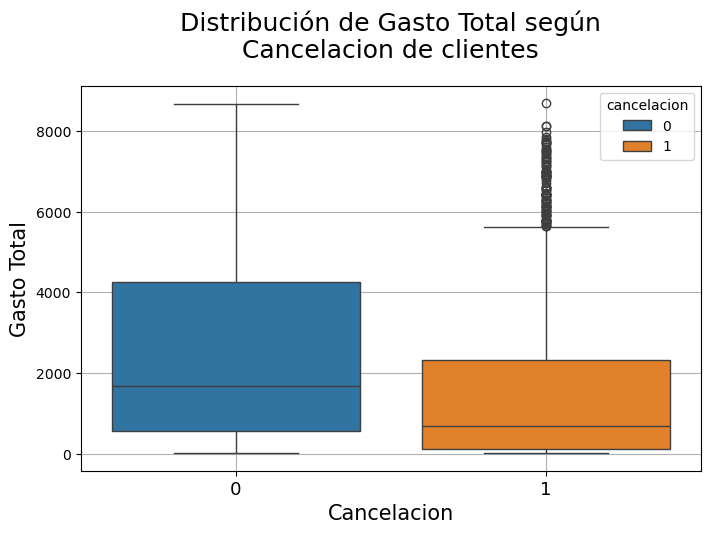

In [43]:
total_boxplot = boxplot_churn(df, ycol='cuentas_total', ylabel='Gasto Total', title_translate='Gasto Total')

> El gasto total es de naturaleza acumulativa muy relacionada con la antiguedad del cliente. Esto puede generar redundancia en el modelo. Vamos a probar considerando todas las variable y luego omitiendo cuentas_total.

## __Division de Datos__

Vamos a dividir los datos de los tres conjuntos de datos _df_, _df_scale_ y _df_linear_ mediante train_test_split. Cada conjunto se divide en 76.5% de entrenamiento, 8.5% de validacion y 15% de prueba.

__Conjunto X__

In [44]:
# Separar las variables predictoras y target
X = df.drop('cancelacion', axis=1)
y = df['cancelacion']

# dividir conjunto de prueba
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# dividir conjunto entrenamiento y validacion
X_train, X_val, y_train, y_val = train_test_split(X_cv, y_cv, test_size=0.10, stratify=y_cv, random_state=42)

__Conjunto X_scale__

In [45]:
# separar las variables predictoras y target
X_scale = df_scale.drop('cancelacion', axis=1)
y_scale = df_scale['cancelacion']

# dividir conjunto de prueba
X_scale_cv, X_scale_test, y_scale_cv, y_scale_test = train_test_split(X_scale, y_scale, test_size=0.15, stratify=y_scale, random_state=42)

# dividir conjunto de entrenamiento y validacion
X_scale_train, X_scale_val, y_scale_train, y_scale_val = train_test_split(X_scale_cv, y_scale_cv, test_size=0.10, stratify=y_scale_cv, random_state=42)

__Conjunto X_linear__

In [46]:
# separar las variables predictoras y target
X_linear = df_linear.drop('cancelacion', axis=1)
y_linear = df_linear['cancelacion']

# dividir conjunto de prueba
X_linear_cv, X_linear_test, y_linear_cv, y_linear_test = train_test_split(X_linear, y_linear, test_size=0.15, stratify=y_linear, random_state=42)

# dividir conjunto de entrenamiento y validacion
X_linear_train, X_linear_val, y_linear_train, y_linear_val = train_test_split(X_linear_cv, y_linear_cv, test_size=0.10, stratify=y_linear_cv, random_state=42)

## __Escalado de variables numericas__

In [47]:
var_num = ['meses_contrato', 'cuenta_mensual', 'cuentas_total']
var_num_scaled = ['scaler_meses_contrato', 'scaler_cuenta_mensual', 'scaler_cuentas_total']

__Conjunto X_scale__

In [48]:
X_scale_cv

# intanciamos el escalador
robust_scaler = RobustScaler()

# ajustamos solo en los datos de entrenmiento (X_cv)
robust_scaler.fit(X_scale_cv[var_num])

# transformar todos los datasets usando el mismo scaler
X_scaled_cv = X_scale_cv.copy()
y_scaled_cv = y_scale_cv.copy()
X_scaled_train = X_scale_train.copy()
y_scaled_train = y_scale_train.copy()
X_scaled_val = X_scale_val.copy()
y_scaled_val = y_scale_val.copy()
X_scaled_test = X_scale_test.copy()
y_scaled_test = y_scale_test.copy()

X_scaled_cv[var_num_scaled] = robust_scaler.transform(X_scale_cv[var_num])
X_scaled_train[var_num_scaled] = robust_scaler.transform(X_scale_train[var_num])
X_scaled_val[var_num_scaled] = robust_scaler.transform(X_scale_val[var_num])
X_scaled_test[var_num_scaled] = robust_scaler.transform(X_scale_test[var_num])

X_scaled_cv.drop(var_num, axis=1, inplace=True)
X_scaled_train.drop(var_num, axis=1, inplace=True)
X_scaled_val.drop(var_num, axis=1, inplace=True)
X_scaled_test.drop(var_num, axis=1, inplace=True)

X_scaled_cv.head()


,genero_Masculino,jubilado_Si,en_pareja_Si,dependientes_Si,servicio_telefonico_Si,multiples_lineas_No,multiples_lineas_Si,multiples_lineas_sin servicio teleonico,servicio_internet_DSL,servicio_internet_Fibra_optica,...,tipo_contrato_mes a mes,tipo_contrato_un year,facturacion_electronica_Si,metodo_pago_cheque electronico,metodo_pago_cheque por correo,metodo_pago_tarjeta de credito,metodo_pago_transferencia,scaler_meses_contrato,scaler_cuenta_mensual,scaler_cuentas_total
134,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.553191,0.256198,-0.340435
4974,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.914894,-0.849403,0.101150
6262,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.553191,-0.389348,-0.359870
2718,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.468085,0.452709,-0.216626
3924,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.191489,-0.938476,-0.299150


__Conjunto X_linear__

In [49]:
robust_scaler_linear = RobustScaler()

X_linear_cv[var_num_scaled] = robust_scaler_linear.fit_transform(X_linear_cv[var_num])
X_linear_train[var_num_scaled] = robust_scaler_linear.transform(X_linear_train[var_num])
X_linear_val[var_num_scaled] = robust_scaler_linear.transform(X_linear_val[var_num])
X_linear_test[var_num_scaled] = robust_scaler_linear.transform(X_linear_test[var_num])

X_linear_cv.drop(var_num, axis=1, inplace=True)
X_linear_train.drop(var_num, axis=1, inplace=True)
X_linear_val.drop(var_num, axis=1, inplace=True)
X_linear_test.drop(var_num, axis=1, inplace=True)

X_linear_cv.head()

,genero_Masculino,jubilado_Si,en_pareja_Si,dependientes_Si,servicio_telefonico_Si,multiples_lineas_Si,multiples_lineas_sin servicio teleonico,servicio_internet_Fibra_optica,No_servicio_internet,seguridad_online_Si,...,streaming_peliculas_Si,tipo_contrato_mes a mes,tipo_contrato_un year,facturacion_electronica_Si,metodo_pago_cheque por correo,metodo_pago_tarjeta de credito,metodo_pago_transferencia,scaler_meses_contrato,scaler_cuenta_mensual,scaler_cuentas_total
134,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.553191,0.256198,-0.340435
4974,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.914894,-0.849403,0.101150
6262,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.553191,-0.389348,-0.359870
2718,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.468085,0.452709,-0.216626
3924,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.191489,-0.938476,-0.299150


## __Balanceo del dataset__

Vamos a visualizar la proporcion de clientes que cancelan y no cancelan.

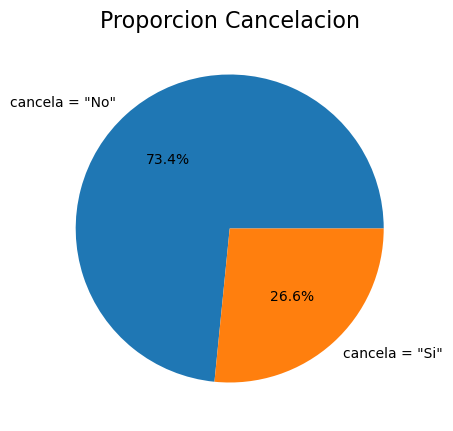

In [50]:
cancelan = df.groupby('cancelacion')['cancelacion'].value_counts()
cancelan = pd.DataFrame(cancelan)

fig, ax = plt.subplots(figsize=(6,5))
ax = plt.pie(
    data=cancelan,
    x=cancelan['count'],
    labels=['cancela = "No"', 'cancela = "Si"'],
    autopct='%1.1f%%'
    )

plt.title('Proporcion Cancelacion', fontsize=16)
plt.show()

> La distribucion de clases esta desbalanceada: aproximadamente 75% de los registros corresponden a clientes que no han abandonado la empresa. 

> Tal desproporcion puede sesgar el modelo durante el entrenamiento dificultando su capacidad para aprender correctamente los patrones 

> Se requiere aplicar una estrategia de balanceo en los datos de entrenamiento pero solo sobre estos para evitar el fenomeno conocido como Data Leakage

> Utilizamos una tecnica de undersampling de la clase mayoritaria llamada NearMiss la cual selecciona los ejemplos mas relevantes de la clase mayoritaria, conservando los casos mas dificiles de clasificar lo que puede contribuir a mejorar la capacidad del modelo para detectar cancelaciones.

> Existen tecnicas como SMOTE que generan nuevas observaciones sinteticas de la clase minoritaria. Estas podrian inducir patrones artificiales que no se corresponden con la realidad del negocio. Esta tenica funciona para situaciones controladas.

In [51]:
columnas = df.columns
columnas, len(columnas)

(Index(['genero_Masculino', 'jubilado_Si', 'en_pareja_Si', 'dependientes_Si',
        'servicio_telefonico_Si', 'multiples_lineas_No', 'multiples_lineas_Si',
        'multiples_lineas_sin servicio teleonico', 'servicio_internet_DSL',
        'servicio_internet_Fibra_optica', 'No_servicio_internet',
        'seguridad_online_Si', 'respaldo_online_Si',
        'proteccion_dispositivo_Si', 'soporte_efectivo_Si', 'streaming_TV_Si',
        'streaming_peliculas_Si', 'tipo_contrato_dos years',
        'tipo_contrato_mes a mes', 'tipo_contrato_un year',
        'facturacion_electronica_Si', 'metodo_pago_cheque electronico',
        'metodo_pago_cheque por correo', 'metodo_pago_tarjeta de credito',
        'metodo_pago_transferencia', 'meses_contrato', 'cuenta_mensual',
        'cuentas_total', 'cancelacion'],
       dtype='object'),
 29)

In [52]:
# Balanceo de los datos
undersampler = NearMiss(version=3)

__Conjunto X__

In [53]:
X_cv, y_cv = undersampler.fit_resample(X_cv, y_cv)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

# y de entrenamiento
y_cv.value_counts()

cancelacion
0    1589
1    1589
Name: count, dtype: int64

In [54]:
y_train.value_counts()

cancelacion
0    1430
1    1430
Name: count, dtype: int64

__Conjunto X_linear__

In [55]:
X_linear_cv, y_linear_cv = undersampler.fit_resample(X_linear_cv, y_linear_cv)
X_linear_train, y_linear_train = undersampler.fit_resample(X_linear_train, y_linear_train)

y_linear_cv.value_counts()

cancelacion
0    1589
1    1589
Name: count, dtype: int64

In [56]:
y_linear_train.value_counts()

cancelacion
0    1430
1    1430
Name: count, dtype: int64

__Conjunto X_scaled__

In [57]:
X_scaled_cv, y_scaled_cv = undersampler.fit_resample(X_scaled_cv, y_scaled_cv)
X_scaled_train, y_scaled_train = undersampler.fit_resample(X_scaled_train, y_scaled_train)

y_scaled_cv.value_counts()

cancelacion
0    1589
1    1589
Name: count, dtype: int64

In [58]:
y_scaled_train.value_counts()

cancelacion
0    1430
1    1430
Name: count, dtype: int64

## __Baseline Model - Arbol de Decision__

In [59]:
# forma de las variables predictoras preprocesadas
X_cv.shape

(3178, 28)

### Analisis de Validacion Cruzada

Vamos a crear una funcion que calcula e imprime el intervalo de confianza del 95% para una métrica de evaluación, a partir de los resultados de validación cruzada. Este análisis ayuda a entender la variabilidad del desempeño del modelo y en qué rango se espera que se encuentre la métrica seleccionada (ej. recall, precisión, F1).

In [60]:
def cv_score_interval(results, 
                      nombre: str, 
                      score:str='Recall'):
   
    score_mean = np.round(results['test_score'].mean(), 4)
    score_stdev = np.round(results['test_score'].std(), 4)
    lower_b = np.round(score_mean - 2 * score_stdev, 4)
    upper_b = np.round(min(1, score_mean + 2 * score_stdev), 4)
    
    print(f'Recall promedio de {nombre}: {score_mean}')
    print(f'Desviación estándar del Recall de {nombre}: {score_stdev}')
    print(f'El {score} de {nombre} estará entre [{lower_b:.4f},{upper_b:.4f}] con un 95% de confianza')

Aplicamos la validacion cruzada estratificada al modelo base.

In [61]:
# Definir Validacion
# 6 particiones. Mezcla los datos antes de dividirlos
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# instanciar modelo base
# profundidad de 10
baseline_model = DecisionTreeClassifier(max_depth=10, random_state=42)

# Validacion cruzada estratificada del modelo base
# calcula recall como metrica de desempeno
baseline_cross_val_results = cross_validate(baseline_model, X_cv, y_cv, cv=skf, scoring='recall')

cv_score_interval(
    results=baseline_cross_val_results,
    nombre='Modelo Base',
    score='Recall'
    )

Recall promedio de Modelo Base: 0.6394
Desviación estándar del Recall de Modelo Base: 0.0298
El Recall de Modelo Base estará entre [0.5798,0.6990] con un 95% de confianza


> El modelo identifica alrededor del 63.9% de los casos en los que los clientes cancelan. Deja escapar cerca del 36%.

> La desviacion estandar es baja lo que significa que el modelo es estable. Generaliza bien y no depende fuertemente del conjunto de entrenamiento

> Con un 95% de confianza, el verdadero recall del modelo en nuevos datos estara entre 57.9% y 69.9%, un rango bastante amplio que se puede mejorar.

### Entrenamiento y evaluacion del modelo

Entrenamos el modelo base

In [62]:
baseline_model.fit(X_cv, y_cv)

DecisionTreeClassifier(max_depth=10, random_state=42)

Obtenemos un reporte detallado del desempeno del modelo base en el conjunto de prueba

In [63]:
# predicciones del modelo con los datos de prueba
baseline_pred = baseline_model.predict(X_test)
print(classification_report(y_test, baseline_pred))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       775
           1       0.44      0.64      0.52       280

    accuracy                           0.69      1055
   macro avg       0.64      0.67      0.65      1055
weighted avg       0.74      0.69      0.70      1055



__Clase 0 (Clientes que permanecen con la empresa)__

> Cuando el modelo predice que un cliente permanece, acierta el 84% de las veces (Precision 0.84).
> Detecta correctamente al 71% de los clientes que permanecen (Recall 0.71).
> Es una clase con un buen equilibrio entre precision y recall (F1-score 0.77).
> 775 clientes permanecen con la empresa y son la mayoria.

__Clase 1 (Clientes que cancelan el servicio con la empresa)__
> Cuando el modelo predice que un cliente cancelara, acierta solo el 44% de las veces.
> Captura correctamente el 64% de los clientes que cancelan (Recall 0.64).
> Es una clase con un balance moderado entre precision y recall (F1-score 0.52).
> 280 clientes permanecen con la empresa y son la mayoria.

__Metricas Generales__
> El modelo acierta en el 69% de los casos. Debido a que las clases estan desbalanceadas, esta metrica puede estar influenciada por la clase mayoritaria por tanto, debemos observar otras metricas para obtener una evaluacion confiable del modelo.

Definimos una funcion que grafique la matriz de confusión de un modelo para visualizar los resultados anteriores.

In [64]:
def plot_mat_confusion(model,
                  x: pd.core.frame.DataFrame, 
                  y: pd.core.series.Series, 
                  name: str,
                  umbral: float=None):
    
    if umbral == None:
        y_pred = model.predict(x)
    else:
        y_probs = model.predict_proba(x)[:, 1]
        y_pred = (y_probs >= umbral).astype(int) 
        
    confmat = confusion_matrix(y_true=y, y_pred=y_pred)

    confmat_plot = ConfusionMatrixDisplay(confmat, display_labels=['Permanecen', 'Cancelan'])

    fig, ax = plt.subplots(figsize=(10,6))
    confmat_plot.plot(ax=ax, colorbar=False, text_kw={'color': 'black', 'fontweight': 'bold'})

    plt.title(name, fontsize=18, fontweight='bold')
    plt.xlabel('Etiquetas Prediccion', fontsize=16)
    plt.ylabel('Etiquetas Reales ', fontsize=16)
    plt.tick_params(axis='both', labelsize=13)
    
    plt.subplots_adjust(right=0.88)
    plt.tight_layout(pad=3.0)
    plt.show()

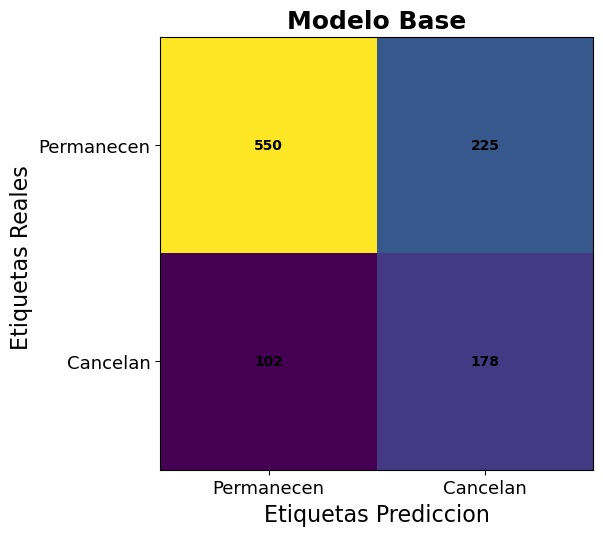

In [65]:
# Matriz de confusion
plot_mat_confusion(baseline_model, X_test, y_test, 'Modelo Base')

Definimos una funcion que calcule las metricas de modelos de clasificacion

In [66]:
def metricas_evaluacion(modelo, 
                       x_test: pd.core.frame.DataFrame,
                       y_test: pd.core.series.Series,
                       nombre: str,
                       conjunto: str,
                       umbral: float=None):
    
    if umbral == None:
        metricas = {}
        y_pred = modelo.predict(x_test)
        metricas['Model'] = nombre
        metricas['Dataset'] = conjunto
        metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
        metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
        metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
        metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(x_test)[:, 1]
            metricas['AUC'] = np.round(roc_auc_score(y_test, y_proba), 4)
        else:
            metricas['AUC'] = '---'
        metricas['Umbral'] = 0.50
    else:
        if hasattr(modelo, "predict_proba"):
            metricas = {}
            probs = modelo.predict_proba(x_test)[:, 1]
            y_pred = (probs >= umbral).astype(int)
            metricas['Model'] = nombre
            metricas['Dataset'] = conjunto
            metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
            metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
            metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
            metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
            metricas['AUC'] = np.round(roc_auc_score(y_test, probs), 4)
            metricas['Umbral'] = umbral
        else:
            raise ValueError('El modelo no cuenta con el método "predict_proba"')
    
    return metricas

Aplicamos la funcion anterior al modelo base y obtenemos las metricas de interes

In [70]:
metricas_evaluacion(
    modelo=baseline_model,
    x_test=X_test,
    y_test = y_test,
    nombre='Modelo Base',
    conjunto='X'
    )

{'Model': 'Modelo Base',
 'Dataset': 'X',
 'Accuracy': np.float64(0.69),
 'Precision': np.float64(0.4417),
 'Recall': np.float64(0.6357),
 'F1-score': np.float64(0.5212),
 'AUC': np.float64(0.7301),
 'Umbral': 0.5}

> El modelo acierta el 69% de las predicciones totales (Accuracy). Si las clases estan desbalanceadas, esta metrica podria estar sesgada.

> El 44.17% de las veces que el modelo predice que un cliente cancelara el servicio, esta en lo correcto (Precision). Implica una alta cantidad de falsos positivos.

> El modelo logra detectar el 63.57% de los clientes que efectivamente cancelan el servicio (Recall).

> Un 52% en F1-score sugiere un balance regular entre precision y recall sin destacar demasiado en ninguno de los dos aspectos.

> El modelo distingue correctamente entre clases positivas y negativas en un 73% de los casos (AUC)

> Es uso un umbral estandar de 0.5 para clasificar.

__El obejtivo del proyecto es detectar clientes en riesgo de cancelar el servicio con la empresa. Para ello trabajaremos en mejorar la sensibilidad sin sacrificar excesivamente la precision ya que demasiados errores en precision pueden llevar a campanas de retencion ineficientes en costos, lo que conlleva a intervenciones innecesarias sobre clientes que continuaran con la empresa__

### Curva ROC del Modelo Base

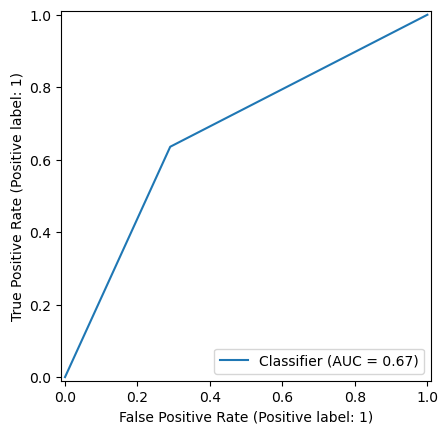

In [71]:
RocCurveDisplay.from_predictions(y_test, baseline_pred);

EL __AUC-ROC__ mide que tan bien un modelo distingue entre clases binarias. 

El __ROC__ Muestra el compromiso entre sensibilidad y la tasa de falsos positivos a diferentes umbrales de clasificacion. Cada punto de la curva representa el rendimiento del modelo para un umbral de decision diferente. El eje X mide cuantos negativos fueron clasificados incorrectamente como positivos. El eje Y mide cuantos positivos reales fueron correctamente detectados.

El __AUC__ es el area bajo la curva __ROC__. Si AUC = 1, el modelo clasifica perfectamente todas las instancias. Si AUC = 0.5 el modelo no tiene poder predictivo y si AUC < 0.5 el modelo predice pero que el azar.